In [57]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import norm
from scipy.signal import find_peaks, butter, sosfilt
import font_manager

matplotlib.rcParams['font.serif'] = "Charter"
matplotlib.rcParams['font.family'] = "serif"

# Overview

All code based on instructions found in the [video here.](https://www.youtube.com/watch?app=desktop&v=jrWDBkeOVQY&t=516s&pp=2AGEBJACAQ%3D%3D)

# Data Loading
This code goes through each folder in 'Back_EMF_Data_Drill' and extracts all the csvs into a big dictionary 'dataframes'. The name and size of all of these entries are printed, ensure that all data is found before proceeding.

In [58]:
# Directory containing the CSV files
repo_path = 'Tests'

# Dictionary to store DataFrames
dataframes = {}

for foldername in os.listdir(repo_path):
    folder_path = os.path.join(repo_path, foldername)
# Loop through all files in the directory
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            # Read the CSV file and skip the header row
            file_path = os.path.join(folder_path, filename)
            df_name = os.path.splitext(filename)[0]
            df = pd.read_csv(file_path, skiprows=1, usecols=[0, 1])
            times = df.iloc[:, 0]
            times = [time_point+abs(times[0]) for time_point in times]
            voltages = df.iloc[:,1]
            # Store the lists in the dictionary
            dataframes[f"{df_name.replace('RTB2004_', '')}_{foldername}"] = {'times': list(times), 'voltages': list(voltages)}

dataframes = dict(sorted(dataframes.items()))

for experiment in dataframes:
    print(f"{experiment} has {len(dataframes[experiment]['times'])} data points")


CHAN1_0250rpm1 has 130895 data points
CHAN1_0250rpm2 has 130895 data points
CHAN1_0250rpm3 has 130895 data points
CHAN1_0500rpm1 has 130439 data points
CHAN1_0500rpm2 has 130439 data points
CHAN1_0500rpm3 has 130439 data points
CHAN1_1000rpm1 has 129311 data points
CHAN1_1000rpm2 has 129311 data points
CHAN1_1000rpm3 has 129311 data points
CHAN2_0250rpm1 has 130895 data points
CHAN2_0250rpm2 has 130895 data points
CHAN2_0250rpm3 has 130895 data points
CHAN2_0500rpm1 has 130439 data points
CHAN2_0500rpm2 has 130439 data points
CHAN2_0500rpm3 has 130439 data points
CHAN2_1000rpm1 has 129311 data points
CHAN2_1000rpm2 has 129311 data points
CHAN2_1000rpm3 has 129311 data points
CHAN3_0250rpm1 has 130895 data points
CHAN3_0250rpm2 has 130895 data points
CHAN3_0250rpm3 has 130895 data points
CHAN3_0500rpm1 has 130439 data points
CHAN3_0500rpm2 has 130439 data points
CHAN3_0500rpm3 has 130439 data points
CHAN3_1000rpm1 has 129311 data points
CHAN3_1000rpm2 has 129311 data points
CHAN3_1000rp

In [181]:
def nice_plot_please(x, y, title, x_label, y_label):
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, label="Voltage", color="black")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)

def nice_plot_please_two(x1, y1, x2, y2, title, x_label, y_label,data_name1,data_name2):
    plt.figure(figsize=(5, 3))
    plt.plot(x1, y1,label=data_name1)
    plt.plot(x2, y2,label=data_name2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)

def nice_plot_please_three(x1, y1, x2, y2, x3, y3, title, x_label, y_label, data_name1, data_name2, data_name3):
    plt.figure(figsize=(7, 4))
    plt.plot(x1, y1, label=data_name1, color='black', markevery=600, marker='.')
    plt.plot(x2, y2, label=data_name2,color='black',markevery=1200,marker='x')
    plt.plot(x3, y3, label=data_name3,color='black')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()
    plt.show(block=False)

# Centering Data
Here each experiment is shifted up and down to centre around 0 and a dictionary "centred_data" is generated containing this..

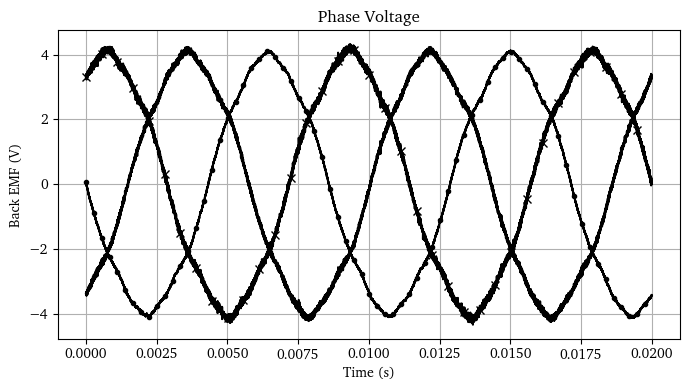

In [184]:
#dictionary of experiments, indexes as [value][0], 0 is time, 1 is voltage
example='CHAN1_1000rpm1'

#centering data about 0
centered_data = {}
for experiment in dataframes:
    mean = np.mean(dataframes[experiment]['voltages'])
    centered_data[experiment]= {'times': dataframes[experiment]['times'], 'voltages' : [v - mean for v in dataframes[experiment]['voltages']]}
    if "CHAN3" in experiment:
        centered_data[experiment]['voltages'] = [v * 10 for v in centered_data[experiment]['voltages']]
#dictionary of experiments, indexes as [value][0], 0 is time, 1 is voltage
#nice_plot_please_two(dataframes[example]['times'],dataframes[example]['voltages'],centered_data[example]['times'],centered_data[example]['voltages'],"Centered Data","Time","Voltage","Original","Centered")
# Filter data to only include the first 0.01 seconds
time_limit = 0.02
filtered_data = {
    key: {
        'times': [t for t in value['times'] if t <= time_limit],
        'voltages': value['voltages'][:len([t for t in value['times'] if t <= time_limit])]
    }
    for key, value in centered_data.items()
}

nice_plot_please_three(
    filtered_data['CHAN1_1000rpm1']['times'], filtered_data['CHAN1_1000rpm1']['voltages'],
    filtered_data['CHAN2_1000rpm1']['times'], filtered_data['CHAN2_1000rpm1']['voltages'],
    filtered_data['CHAN3_1000rpm1']['times'], filtered_data['CHAN3_1000rpm1']['voltages'],
    "Phase Voltage", "Time (s)", "Back EMF (V)", "Original", "Centered", "Centered"
)


In [131]:
def waveform_data_info(experiment,data=centered_data,window_start=0,window_size=0,voltage_threshold=.5,plot=False,filter=False,dist=1,prom=0.1,distance_factor=2.0):
    test_data = data[experiment]
    if filter == True:
        # Compute the Fourier Transform of the voltages
        N = len(test_data['voltages'])
        T = (test_data['times'][100] - test_data['times'][0]/100)  # Sample spacing
        time_step = T

        yf = fft(test_data['voltages'])
        xf = fftfreq(N, T)[:N//2]

        # Compute the power spectrum
        power = 2.0/N * np.abs(yf[:N//2])

        # Find the peaks in the power spectrum
        peaks, _ = find_peaks(power, height=0.1)

        #bandpass filter
        sos = signal.butter(2, 5*xf[peaks][0], 'low', fs=1/time_step, output='sos')
        filtered = signal.sosfilt(sos, test_data['voltages'])
        test_data['voltages'] = filtered
        
    if window_size==0:
        window_size = len(test_data['times'])

    # Adjust the distance and prominence parameters to widen the tolerance for peak detection
    #thres = np.floor(max(test_data['voltages'])/4)
    peaks_positive, _ = find_peaks(test_data['voltages'][window_start:window_start+window_size], height=voltage_threshold, distance=dist,prominence=prom)
    peaks_negative, _ = find_peaks(-np.array(test_data['voltages'][window_start:window_start+window_size]), height=voltage_threshold, distance=dist,prominence=prom)
    peaks = np.concatenate((peaks_positive, peaks_negative))
    peaks=np.sort(peaks)
    peaks = peaks+window_start

    # Calculate the distance between consecutive peaks in time and voltage and calculate constant
    peak_times = []
    peak_voltage = []
    peak_pairs = []
    for i in range(0, len(peaks) - 1, 2):
        time_distance = test_data['times'][peaks[i+1]] - test_data['times'][peaks[i]]
        if i>0:
            if time_distance>distance_factor*peak_times[-1]:
                continue
        peak_pairs.append((peaks[i], peaks[i+1]))
        voltage_distance = test_data['voltages'][peaks[i+1]] - test_data['voltages'][peaks[i]]
        peak_times.append(time_distance)
        peak_voltage.append(voltage_distance)

    peak_to_peak_time = np.mean(np.abs(peak_times))*2 #time between peaks, scale by 2 as that's how it's been calculated
    peak_to_peak_voltage = np.mean(np.abs(peak_voltage))

    if plot == True:
        plt.figure(figsize=(5, 3))
        plt.plot(test_data['times'][window_start:window_start+window_size], test_data['voltages'][window_start:window_start+window_size], label="Voltage", color="black")
        for i, (pair) in enumerate(peak_pairs):
            plt.plot([test_data['times'][pair[0]], test_data['times'][pair[1]]], [test_data['voltages'][pair[0]], test_data['voltages'][pair[1]]], "x")
        plt.title("Voltage Peaks")
        plt.xlabel("Time")
        plt.ylabel("Voltage")
        plt.grid(True)
        plt.tight_layout()

        plt.show(block=False)

    return (peak_to_peak_time, peak_to_peak_voltage)

In [86]:
def torque_finder(period, voltage, pole_pairs = 0, wind_type=None):
    if pole_pairs == 0:
        print("Must define number of pole pairs")
        return None
    if wind_type == None:
        print("Must define winding type, True for Delta, False for Wye")
        return None
    elif wind_type == True:
        #### Delta Winding
        torque_constant = (voltage/2)/((np.sqrt(2/3)*(1/period)*2*np.pi/pole_pairs))
        return torque_constant
    elif wind_type == False:
        #### Wye Winding
        torque_constant = (voltage/2)/((np.sqrt(2)*(1/period)*2*np.pi/pole_pairs))
    return torque_constant

#### Determining Constants  
Torque constant and back EMF constant found via:

$$K_b^q=K^q_t$$
Wye: $\bar V^H = \sqrt{2} V^q=\sqrt{2}K^q_b\frac{d\theta _m}{dt}$

Delta: $\bar V^H = \sqrt{\frac{2}{3}} V^q=\sqrt{\frac{2}{3}}K^q_b\frac{d\theta _m}{dt}$

#### Recreating Original Video to test code
Original signal was 9.5V pk to pk, 151.6Hz, 21 pole pairs, Delta obtaining a torque constant of $$0.13NmA^{-1}$$

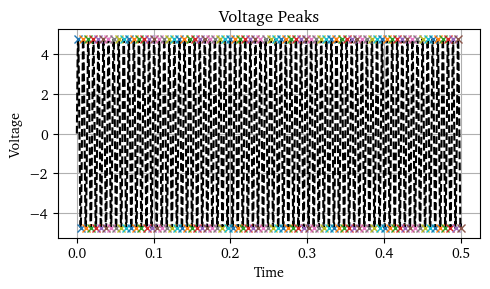

Constant = 0.13 Nm/A


In [124]:
test_t = np.linspace(0, 0.5, 5000) #example time array
test_signal = (9.5/2) * np.sin(151.6 * 2* np.pi * test_t) #example signal
#nice_plot_please(test_t,test_signal,"Test Signal","Time","Voltage")
example_data = {}
example_data["Test"] = {'times': test_t, 'voltages': test_signal}
[test_period,test_voltage] = waveform_data_info("Test",example_data,window_start=0,window_size=0,voltage_threshold=.5,plot=True)
test_constant = torque_finder(test_period,test_voltage,21,True)
print(f"Constant = {round(test_constant, 2)} Nm/A")

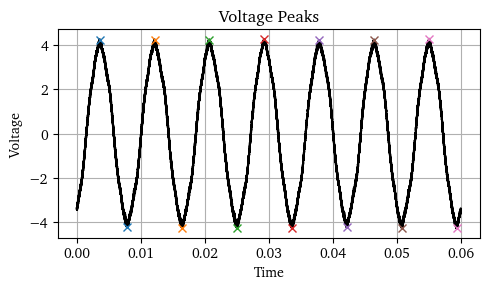

In [132]:
example = "CHAN3_1000rpm1"
(example_half_period,example_pk2pk)=waveform_data_info(example,voltage_threshold=.5,plot=True,dist=200,prom=.5,distance_factor=2)


In [89]:
all_back_torque_constant = []
experiment_start_points=[0]
for experiment in centered_data:
    i=0
    #print(f"Experiment: {experiment}")
    (period, voltage) = waveform_data_info(experiment, data=centered_data, voltage_threshold=0.5, plot=False, dist=200, prom=0.5, distance_factor=2)
    torque_constant = torque_finder(period,voltage,7,True)
    all_back_torque_constant.extend([torque_constant])
    experiment_start_points.append(all_back_torque_constant[i]+len(all_back_torque_constant))
    i+=1

Mean: 0.04954087607322352, Standard Deviation: 0.0006867196153078932


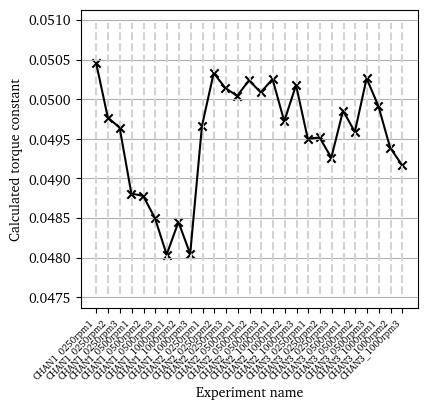

In [107]:
padding = 0.0005
for i, label in enumerate(centered_data.keys()):
    plt.vlines(experiment_start_points[i], min(all_back_torque_constant)-padding, max(all_back_torque_constant)+padding, color='lightgrey', linestyle='--')
plt.plot(all_back_torque_constant, color='black')
plt.scatter(range(len(all_back_torque_constant)), all_back_torque_constant, color='black', marker='x')
print(f"Mean: {np.mean(all_back_torque_constant)}, Standard Deviation: {np.std(all_back_torque_constant)}")
plt.xticks(ticks=experiment_start_points[:-1], labels=list(centered_data.keys()), rotation=45, fontsize=7, ha='right')
plt.xlabel("Experiment name")
plt.ylabel("Calculated torque constant")
plt.tight_layout()
plt.grid(axis='y')
plt.gcf().set_size_inches(4, 4)
plt.show()